In [3]:
import osmnx as ox
import math
from shapely.geometry import Point, LineString, Polygon
from shapely.affinity import rotate
import networkx as nx
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.lib.maps.map import Intersection, Road, RoadString, Node, SubNode


In [28]:
def convert_to_traffic_graph(intersections_inp, roads_inp):
    """

    :param intersections_inp: dict with intersection ID as key and the tuple (x,y) as value
    :param roads_inp: dict with road ID as key and the intersection tuple(id1, id2) as value. Directed road.
    :return: ToDo
    """

    intersections_table = dict.fromkeys(intersections_inp.keys())
    roads_table = dict.fromkeys(roads_inp.keys())
    tg = nx.DiGraph()

    for r_id, r in roads_inp.items():
        if intersections_table[r[0]] is None:
            I = intersections_inp[r[0]]
            intersections_table[r[0]] = Intersection(point_x=I[0], point_y=I[1], osmid=r[0])

        if intersections_table[r[1]] is None:
            I = intersections_inp[r[1]]
            intersections_table[r[1]] = Intersection(point_x=I[0], point_y=I[1], osmid=r[1])

        print(r_id)
        if roads_table[r_id] is None:
            print('yes')
            line_string = LineString([intersections_inp[r[0]], intersections_inp[r[1]]])
            road, start_node, end_node = create_road(start_intersection=intersections_table[r[0]],
                                                     end_intersection=intersections_table[r[1]],
                                                     name=None, osmid=r_id, road_string=RoadString(line_string))
            tg.add_node(start_node.get_id(), object=start_node)
            tg.add_node(end_node.get_id(), object=end_node)
            tg.add_edges_from([(start_node.get_id(), end_node.get_id(), {'object': road,
                                                                         'distance': road.get_road_length(),
                                                                         'traffic': None})])

            road, start_node, end_node = create_road(start_intersection=intersections_table[r[0]],
                                                     end_intersection=intersections_table[r[1]],
                                                     name=None, osmid=r_id, road_string=RoadString(line_string))
            tg.add_node(start_node.get_id(), object=start_node)
            tg.add_node(end_node.get_id(), object=end_node)
            tg.add_edges_from([(start_node.get_id(), end_node.get_id(), {'object': road,
                                                                         'distance': road.get_road_length(),
                                                                         'traffic': None})])
            roads_table[r_id] = road

    # Add turn roads, and assign traffic controller to the intersections

    for id_, I in intersections_table.items():

        for i_node in I.get_nodes():
            if i_node.is_incoming():
                iid = i_node.get_id().split("_")[1]
                for o_node in I.get_nodes():
                    if not o_node.is_incoming():
                        oid = o_node.get_id().split("_")[1]
                        if not iid == oid:
                            ls = LineString([(i_node.get_x(), i_node.get_y()), (o_node.get_x(), o_node.get_y())])
                            turn_road = Road(start_node=i_node, end_node=o_node, road_string=RoadString(ls), name='turn',
                                            osmid=i_node.get_id()+str("_")+o_node.get_id())
                            tg.add_edges_from([(i_node.get_id(), o_node.get_id(), {'object': turn_road,
                                                                                   'distance': turn_road.get_road_length(),
                                                                                   'traffic': None})])
                            roads_table[i_node.get_id()+str("_")+o_node.get_id()] = turn_road

    return tg, intersections_table, roads_table


def create_road(start_intersection, end_intersection, name, osmid, road_string):
    """

    :param start_intersection:
    :param end_intersection:
    :param name:
    :param osmid:
    :param road_string:
    :return:
    """

    x1, y1 = start_intersection.get_x(), start_intersection.get_y()
    x2, y2 = end_intersection.get_x(), end_intersection.get_y()

    [p1, p2] = get_node_coords(x1, y1, x2, y2, no_of_lanes=3, lane_width=4)
    # todo: add utils for no of lanes and width

    _id = str(start_intersection.get_osmid()) + "_" + str(osmid) + "_" + str(end_intersection.get_osmid())
    sn1 = Node(point_x=p1[0], point_y=p1[1], incoming=False, parent=start_intersection, _id=_id)
    start_intersection.add_node(sn1)

    _id = str(end_intersection.get_osmid()) + "_" + str(osmid) + "_" + str(start_intersection.get_osmid())
    sn2 = Node(point_x=p2[0], point_y=p2[1], incoming=True, parent=end_intersection, _id=_id)
    end_intersection.add_node(sn2)

    road = Road(start_node=sn1, end_node=sn2, road_string=road_string, name=name, osmid=osmid)

    return road, sn1, sn2


def get_node_coords(x1, y1, x2, y2, no_of_lanes=3, lane_width=4):

    """
    The offset in Point(_ , _) varies if the road is a one way. For now, we only assume two way roads. So each pair of
    intersections has two nodes each along the line joining them, one point each for the one side of the road.
    :param x1:
    :param y1:
    :param x2:
    :param y2:
    :param no_of_lanes:
    :param lane_width:
    :return:
    """
    road_width = no_of_lanes* lane_width
    distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    slope = math.atan2(y2 - y1, x2 - x1)
    fs = (0, 0)
    fe = (distance, 0)

    if abs(slope) <= math.pi / 2:
        # fs1 = Point(10, 0)
        fs2 = Point(10, -road_width/2)

        # fe1 = Point(distance - 10, 0)
        fe2 = Point(distance - 10, -road_width/2)

    else:
        # fs1 = Point(-10, 0)
        fs2 = Point(-10, -road_width/2)

        # fe1 = Point(-distance + 10, 0)
        fe2 = Point(-distance + 10, -road_width/2)

    os2 = rotate(fs2, angle=slope, origin=fs, use_radians=True)
    oe2 = rotate(fe2, angle=slope, origin=fs, use_radians=True)

    return [(x1 + os2.coords[0][0], y1 + os2.coords[0][1]), (x1 + oe2.coords[0][0], y1 + oe2.coords[0][1])]



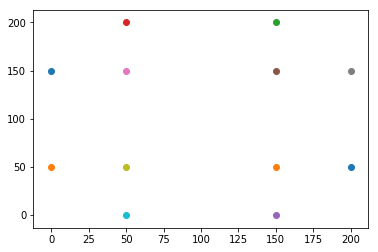

In [18]:
import random
intersections_inp = dict()

intersections_inp["i1"] = (50, 0)
intersections_inp["i2"] = (50, 50)
intersections_inp["i3"] = (0, 50)
intersections_inp["i4"] = (150, 0)
intersections_inp["i5"] = (150, 50)
intersections_inp["i6"] = (200, 50)
intersections_inp["i7"] = (0, 150)
intersections_inp["i8"] = (50, 150)
intersections_inp["i9"] = (50, 200)
intersections_inp["i10"] = (150, 200)
intersections_inp["i11"] = (150, 150)
intersections_inp["i12"] = (200, 150)

%matplotlib inline
from matplotlib import pyplot as plt

for _id, val in intersections_inp.items():
    plt.scatter(val[0], val[1])


In [44]:
roads_inp = dict()

roads_inp["r12"] = ("i1","i2")
roads_inp["r21"] = ("i2","i1")

roads_inp["r23"] = ("i2","i3")
roads_inp["r32"] = ("i3","i2")

roads_inp["r45"] = ("i4","i5")
roads_inp["r54"] = ("i5","i4")

roads_inp["r56"] = ("i5","i6")
roads_inp["r65"] = ("i6","i5")

roads_inp["r78"] = ("i7","i8")
roads_inp["r87"] = ("i8","i7")

roads_inp["r89"] = ("i8","i9")
roads_inp["r98"] = ("i9","i8")

roads_inp["r1011"] = ("i10","i11")
roads_inp["r1110"] = ("i11","i10")

roads_inp["r1112"] = ("i11","i12")
roads_inp["r1211"] = ("i12","i11")

roads_inp["r52"] = ("i5","i2")
roads_inp["r25"] = ("i2","i5")

roads_inp["r28"] = ("i2","i8")
roads_inp["r82"] = ("i8","i2")

roads_inp["r811"] = ("i8","i11")
roads_inp["r118"] = ("i11","i8")

roads_inp["r511"] = ("i5","i11")
roads_inp["r115"] = ("i11","i5")


In [45]:
tg, I, R = convert_to_traffic_graph(intersections_inp, roads_inp)

r56
yes
r12
yes
r45
yes
r1112
yes
r1011
yes
r98
yes
r28
yes
r87
yes
r82
yes
r52
yes
r23
yes
r21
yes
r25
yes
r1110
yes
r78
yes
r32
yes
r89
yes
r1211
yes
r811
yes
r65
yes
r511
yes
r118
yes
r115
yes
r54
yes


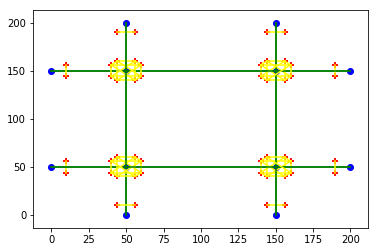

In [48]:
%matplotlib inline
import mpld3
from matplotlib import pyplot as plt

mpld3.enable_notebook()

fig, axis = plt.subplots(1,1)
# print(len(I))
for i, v in I.items():
    axis.scatter(v.get_x(), v.get_y(),marker='o' ,c='blue')
    
    for node in v.get_nodes():
        axis.scatter(node.get_x(), node.get_y(), marker='+', c='red')
        
for edge in tg.edges(data=True):
    road = edge[2]['object']
    if not road.get_name() == 'turn':
#         continue
        road_string = road.get_road_string()
        line_string = road_string.get_line_string()
        x,y = line_string.coords.xy
        axis.plot(x,y, 'green')
    
    else:
        road_string = road.get_road_string()
        line_string = road_string.get_line_string()
        x,y = line_string.coords.xy
        axis.plot(x,y, 'yellow')
        
    
# plt.grid()

In [41]:

def get_node_coords(x1, y1, x2, y2, no_of_lanes=3, lane_width=4):

    """
    The offset in Point(_ , _) varies if the road is a one way. For now, we only assume two way roads. So each pair of
    intersections has two nodes each along the line joining them, one point each for the one side of the road.
    :param x1:
    :param y1:
    :param x2:
    :param y2:
    :param no_of_lanes:
    :param lane_width:
    :return:
    """
    road_width = no_of_lanes* lane_width
    distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    slope = math.atan2(y2 - y1, x2 - x1)
    fs = (0, 0)
    fe = (distance, 0)

    fs2 = Point(10, -road_width/2)

    # fe1 = Point(distance - 10, 0)
    fe2 = Point(distance - 10, -road_width/2)

#     if abs(slope) <= math.pi / 2:
#         # fs1 = Point(10, 0)
#         fs2 = Point(10, -road_width/2)

#         # fe1 = Point(distance - 10, 0)
#         fe2 = Point(distance - 10, -road_width/2)

#     elif abs(slope) == math.pi:
#         fs2 = Point()
        
#     else:
#         # fs1 = Point(-10, 0)
#         fs2 = Point(-10, -road_width/2)

#         # fe1 = Point(-distance + 10, 0)
#         fe2 = Point(-distance + 10, -road_width/2)

    os2 = rotate(fs2, angle=slope, origin=fs, use_radians=True)
    oe2 = rotate(fe2, angle=slope, origin=fs, use_radians=True)

    return [(x1 + os2.coords[0][0], y1 + os2.coords[0][1]), (x1 + oe2.coords[0][0], y1 + oe2.coords[0][1])]



150 50 200 50 (160.0, 44.0) (190.0, 44.0)
50 0 50 50 (56.0, 10.0) (56.0, 40.0)
150 0 150 50 (156.0, 10.0) (156.0, 40.0)
150 150 200 150 (160.0, 144.0) (190.0, 144.0)
150 150 50 50 (138.68629150101523, 147.17157287525382) (52.828427124746185, 61.31370849898475)
150 200 150 150 (144.0, 190.0) (144.0, 160.0)
50 200 50 150 (44.0, 190.0) (44.0, 160.0)
200 50 150 50 (190.0, 56.0) (160.0, 56.0)
50 150 0 150 (40.0, 156.0) (10.0, 156.0)
50 150 150 50 (52.82842712474619, 138.68629150101523) (138.68629150101526, 52.828427124746185)
150 50 50 50 (140.0, 56.0) (60.0, 56.0)
50 50 0 50 (40.0, 56.0) (10.0, 56.0)
50 50 50 0 (44.0, 40.0) (44.0, 10.0)
50 50 150 50 (60.0, 44.0) (140.0, 44.0)
150 150 150 200 (156.0, 160.0) (156.0, 190.0)
0 150 50 150 (10.0, 144.0) (40.0, 144.0)
0 50 50 50 (10.0, 44.0) (40.0, 44.0)
50 150 50 200 (56.0, 160.0) (56.0, 190.0)
200 150 150 150 (190.0, 156.0) (160.0, 156.0)
50 150 150 150 (60.0, 144.0) (140.0, 144.0)
50 150 150 50 (52.82842712474619, 138.68629150101523) (138.6862

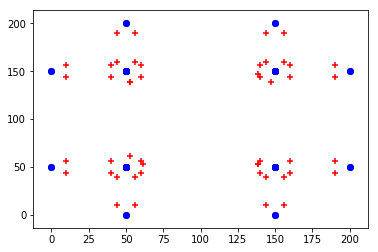

In [43]:
%matplotlib inline

for i, r in roads_inp.items():
    x1,y1 = intersections_inp[r[0]]
    x2,y2 = intersections_inp[r[1]]
    [p1, p2] = get_node_coords(x1,y1,x2,y2)
    print(x1,y1, x2,y2, p1, p2)
    plt.scatter(x1,y1,marker='o',color='blue')
    plt.scatter(x2,y2,marker='o',color='blue')
    
    plt.scatter(p1[0], p1[1],marker='+',color='red')
    plt.scatter(p2[0],p2[1],marker='+',color='red')
#     plt.show()